# Library

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
import rtdl
from typing import Any, Dict


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [19]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Dataset

In [20]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything()

In [21]:
df_train = pd.read_csv('./final_trainset.csv')
df_test = pd.read_csv('./final_testset.csv')

In [22]:
# split dataset
X = {}
y = {}

X['train'] = df_train.iloc[:, :-1]
y['train'] = df_train.benh21

X['test'] = df_test.iloc[:, :-1]
y['test'] = df_test.benh21

X['train'], X['val'], y['train'], y['val'] = train_test_split(X['train'], y['train'], test_size = 0.10, random_state=20)

In [23]:
index = X['train'].select_dtypes(['float64']).columns

# float64 -> float32
X['train'][index] = X['train'][index].apply(lambda x: x.astype('float32'))
X['val'][index] = X['val'][index].apply(lambda x: x.astype('float32'))
X['test'][index] = X['test'][index].apply(lambda x: x.astype('float32'))

# reshape label
y['train'] = np.where(y['train']==1, 1, 0).reshape(-1, 1)
y['val'] = np.where(y['val']==1, 1, 0).reshape(-1, 1)
y['test'] = np.where(y['test']==1, 1, 0).reshape(-1, 1)

<ipython-input-23-2ef0f8e37db9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['test'][index] = X['test'][index].apply(lambda x: x.astype('float32'))


In [24]:
# chuyển dữ liệu và nhãn -> tensor
def RTDL(dataset, label):
    index = dataset['train'].select_dtypes(['float32']).columns
    X = {'train': {},
         'val': {},
         'test': {}}
    y = {'train': {},
         'val': {},
         'test': {}}
    X['train']['num'] = torch.tensor(dataset['train'][index].values, device=device)
    X['val']['num'] = torch.tensor(dataset['val'][index].values, device=device)
    X['test']['num'] = torch.tensor(dataset['test'][index].values, device=device)

    # dtype = float
    y['train'] = torch.tensor(label['train'], dtype=torch.float, device=device)
    y['val'] = torch.tensor(label['val'], dtype=torch.float, device=device)
    y['test'] = torch.tensor(label['test'], dtype=torch.float, device=device)
    return X, y

X, y = RTDL(X, y)

In [25]:
class create_Tensor(Dataset):
    def __init__(self, num, label):
        self.num = num # thuộc tính (tensor)
        self.label = label # nhãn (tensor)
        self.len = self.label.shape[0] # số lượng mẫu 

    def __getitem__(self, index):
        return self.num[index], self.label[index]

    def __len__(self):
        return self.len

In [26]:
train_set = create_Tensor(X['train']['num'], y['train'])
val_set = create_Tensor(X['val']['num'], y['val'])
test_set = create_Tensor(X['test']['num'], y['test'])

# tạo các đối tượng DataLoader
train_load = DataLoader(train_set, batch_size=32, shuffle=True)
val_load = DataLoader(val_set, batch_size=32, shuffle=True)
test_load = DataLoader(test_set, batch_size=32, shuffle=True)

# DataLoader
# dễ dàng truy cập dữ liệu trong quá trình huấn luyện 
# # giúp tăng tốc huấn luyện bằng cách tự động tải và trả dữ liệu theo batch


## Model FT Transformer

In [27]:
num_features = X['train']['num'].shape[1] 
model_ftt = rtdl.FTTransformer.make_baseline(n_num_features=num_features, # số lượng thuộc tính
                                        cat_cardinalities=[], # số lượng phân loại của các thuộc tính phân loại
                                        d_token=64, # số chiều của token (transformer)
                                        n_blocks=3, # số lượng khối transformer
                                        attention_dropout=0.2, # tỷ lệ dropout lớp Attention trong mỗi khối transformer -> tránh overfitting
                                        ffn_d_hidden=128, # số lượng đầu ra của lớp feedforward trong mỗi khối transformer
                                        ffn_dropout=0.1, # tỷ lệ dropout lớp feedforward trong mỗi khối transformer -> tránh overfitting
                                        residual_dropout=0.1, # tỷ lệ dropout lớp residual trong mỗi khối transformer -> tránh overfitting
                                        d_out=1 # kích thước đầu ra
                                        )

model_ftt.to(device)

FTTransformer(
  (feature_tokenizer): FeatureTokenizer(
    (num_tokenizer): NumericalFeatureTokenizer()
  )
  (cls_token): CLSToken()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=64, out_features=64, bias=True)
          (W_k): Linear(in_features=64, out_features=64, bias=True)
          (W_v): Linear(in_features=64, out_features=64, bias=True)
          (W_out): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (ffn): FFN(
          (linear_first): Linear(in_features=64, out_features=256, bias=True)
          (activation): ReGLU()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_second): Linear(in_features=128, out_features=64, bias=True)
        )
        (attention_residual_dropout): Dropout(p=0.1, inplace=False)
        (ffn_residual_dropout): Dropout(p=0.1, inplace=False)
        (o

In [28]:
his = {'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []}

In [29]:
def training(model, dataLoader, criterion, optimizer, scheduler=None):
    model.train() # thiết lập mô hình ở trạng thái train -> bật dropout
    loss_now = 0 # tổng loss
    correlation = 0 # số lượng dự đoán đúng

    for x_num, label in tqdm(dataLoader):
        optimizer.zero_grad() # xóa gradient (đạo hàm) cũ
        x_num = x_num.to(device) 
        label = label.to(device)
        out = torch.sigmoid(model(x_num, None)) # tính toán đầu ra, hàm sigmoid -> đưa về dạng xác suất
        loss = criterion(out, label) # tính toán loss dự đoán - nhãn thực tế
        loss.backward() # tính gradient ngược
        optimizer.step() # cập nhật trọng số dựa trên gradient tính được
        predict = out >= torch.FloatTensor([0.5]).to(device) # chuyển giá trị dự đoán -> nhãn dựa trên ngưỡng 0.5
        correlation += predict.eq(label).sum().item() # tính số lượng dự đoán đúng và cộng vào tổng
        loss_now +=  x_num.size(0) * loss.item() # cộng loss của batch hiện tại vào tổng loss

    if scheduler: # nếu có scheduler -> cập nhật learning rate
        scheduler.step() 

    acc = correlation/len(dataLoader.dataset) # tính accuracy
    his['train_acc'].append(acc)
    loss = loss_now/len(dataLoader.dataset) # tính loss
    his['train_loss'].append(loss)

    return acc, loss

In [30]:
# đánh giá trên tập validation và test
def evaluating(model, dataLoader, criterion):
    model.eval() # thiết lập mô hình ở trạng thái evaluation -> tắt dropout
    predictions = []
    with torch.no_grad(): # không tính gradient
        loss_now = 0 # tổng loss
        correlation = 0 # số lượng dự đoán đúng

        for x_num, label in dataLoader:
            x_num = x_num.to(device)
            label = label.to(device)
            out = torch.sigmoid(model(x_num, None)) # tính toán đầu ra, hàm sigmoid -> đưa về dạng xác suất
            predict = out >= torch.FloatTensor([0.5]).to(device) # chuyển giá trị dự đoán -> nhãn dựa trên ngưỡng 0.5
            predictions.append(predict.cpu().numpy()) # Lưu dự đoán
            correlation += predict.eq(label).sum().item() # tính số lượng dự đoán đúng và cộng vào tổng
            loss_now +=  x_num.size(0) * criterion(out, label).item() # cộng loss của batch hiện tại vào tổng

    acc = correlation/len(dataLoader.dataset) # tính accuracy
    his['val_acc'].append(acc)
    loss = loss_now/len(dataLoader.dataset) # tính loss
    his['val_loss'].append(loss)

    return acc, loss, np.concatenate(predictions)

In [31]:
criterion = nn.BCELoss() # binary cross entropy loss

lr = 0.00001 # learning rate
weight_decay = 0.000041 # Hệ số giảm trọng số 
optimizer = (
    model_ftt.make_default_optimizer() # optimizer mặc định của FTT
    if isinstance(model_ftt, rtdl.FTTransformer) # nếu mô hình là FTT
    else torch.optim.AdamW(model_ftt.parameters(), lr=lr, weight_decay=weight_decay) 
    # AdamW tối ưu mô hình transformer, tối ưu tất cả tham số
)

n_epochs = 100
maxLoss = np.inf

for epoch in range(n_epochs):
    train_acc, train_loss = training(model_ftt, train_load, criterion, optimizer, None)
    val_acc, val_loss, y_val_pred = evaluating(model_ftt, val_load, criterion)
    if maxLoss > val_loss:
        print(f'EPOCH {epoch+1}: Saving state of model')
        maxLoss = val_loss
        torch.save(model_ftt.state_dict(), 'Feature_Tokenizer_Transformer_state.pth')

    print(f'Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}')
    print(f'Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f} \n')


100%|██████████| 123/123 [00:04<00:00, 28.51it/s]


EPOCH 1: Saving state of model
Train Accuracy: 0.5993, Train Loss: 0.6567
Val Accuracy: 0.6849, Val Loss: 0.6043 



100%|██████████| 123/123 [00:01<00:00, 68.97it/s]


EPOCH 2: Saving state of model
Train Accuracy: 0.6766, Train Loss: 0.6019
Val Accuracy: 0.7055, Val Loss: 0.5840 



100%|██████████| 123/123 [00:02<00:00, 52.19it/s]


EPOCH 3: Saving state of model
Train Accuracy: 0.6834, Train Loss: 0.5937
Val Accuracy: 0.7123, Val Loss: 0.5829 



100%|██████████| 123/123 [00:01<00:00, 69.48it/s]


Train Accuracy: 0.6898, Train Loss: 0.5865
Val Accuracy: 0.6804, Val Loss: 0.5885 



100%|██████████| 123/123 [00:01<00:00, 68.42it/s]


Train Accuracy: 0.7025, Train Loss: 0.5741
Val Accuracy: 0.6712, Val Loss: 0.5927 



100%|██████████| 123/123 [00:01<00:00, 70.70it/s]


Train Accuracy: 0.6992, Train Loss: 0.5677
Val Accuracy: 0.6621, Val Loss: 0.5949 



100%|██████████| 123/123 [00:01<00:00, 69.37it/s]


EPOCH 7: Saving state of model
Train Accuracy: 0.7002, Train Loss: 0.5674
Val Accuracy: 0.7100, Val Loss: 0.5665 



100%|██████████| 123/123 [00:01<00:00, 70.29it/s]


Train Accuracy: 0.7116, Train Loss: 0.5557
Val Accuracy: 0.6963, Val Loss: 0.5721 



100%|██████████| 123/123 [00:02<00:00, 61.18it/s]


EPOCH 9: Saving state of model
Train Accuracy: 0.7139, Train Loss: 0.5537
Val Accuracy: 0.7192, Val Loss: 0.5560 



100%|██████████| 123/123 [00:02<00:00, 48.76it/s]


Train Accuracy: 0.7132, Train Loss: 0.5479
Val Accuracy: 0.7169, Val Loss: 0.5604 



100%|██████████| 123/123 [00:02<00:00, 50.56it/s]


Train Accuracy: 0.7259, Train Loss: 0.5418
Val Accuracy: 0.7009, Val Loss: 0.5569 



100%|██████████| 123/123 [00:02<00:00, 60.64it/s]


Train Accuracy: 0.7221, Train Loss: 0.5407
Val Accuracy: 0.7055, Val Loss: 0.5587 



100%|██████████| 123/123 [00:01<00:00, 72.28it/s]


Train Accuracy: 0.7355, Train Loss: 0.5280
Val Accuracy: 0.7123, Val Loss: 0.5632 



100%|██████████| 123/123 [00:01<00:00, 70.90it/s]


EPOCH 14: Saving state of model
Train Accuracy: 0.7185, Train Loss: 0.5371
Val Accuracy: 0.7123, Val Loss: 0.5395 



100%|██████████| 123/123 [00:01<00:00, 66.45it/s]


Train Accuracy: 0.7302, Train Loss: 0.5243
Val Accuracy: 0.6963, Val Loss: 0.5606 



100%|██████████| 123/123 [00:02<00:00, 51.88it/s]


Train Accuracy: 0.7315, Train Loss: 0.5258
Val Accuracy: 0.7123, Val Loss: 0.5424 



100%|██████████| 123/123 [00:01<00:00, 71.15it/s]


EPOCH 17: Saving state of model
Train Accuracy: 0.7386, Train Loss: 0.5195
Val Accuracy: 0.7032, Val Loss: 0.5364 



100%|██████████| 123/123 [00:01<00:00, 71.10it/s]


EPOCH 18: Saving state of model
Train Accuracy: 0.7495, Train Loss: 0.5117
Val Accuracy: 0.7055, Val Loss: 0.5325 



100%|██████████| 123/123 [00:01<00:00, 72.49it/s]


Train Accuracy: 0.7497, Train Loss: 0.5028
Val Accuracy: 0.7100, Val Loss: 0.5411 



100%|██████████| 123/123 [00:01<00:00, 70.62it/s]


EPOCH 20: Saving state of model
Train Accuracy: 0.7576, Train Loss: 0.5045
Val Accuracy: 0.7237, Val Loss: 0.5290 



100%|██████████| 123/123 [00:01<00:00, 70.81it/s]


EPOCH 21: Saving state of model
Train Accuracy: 0.7589, Train Loss: 0.4958
Val Accuracy: 0.7192, Val Loss: 0.5258 



100%|██████████| 123/123 [00:01<00:00, 61.75it/s]


Train Accuracy: 0.7576, Train Loss: 0.4932
Val Accuracy: 0.7237, Val Loss: 0.5344 



100%|██████████| 123/123 [00:02<00:00, 54.59it/s]


EPOCH 23: Saving state of model
Train Accuracy: 0.7630, Train Loss: 0.4919
Val Accuracy: 0.7329, Val Loss: 0.5204 



100%|██████████| 123/123 [00:01<00:00, 69.19it/s]


Train Accuracy: 0.7541, Train Loss: 0.4944
Val Accuracy: 0.7146, Val Loss: 0.5269 



100%|██████████| 123/123 [00:01<00:00, 68.54it/s]


EPOCH 25: Saving state of model
Train Accuracy: 0.7617, Train Loss: 0.4821
Val Accuracy: 0.7260, Val Loss: 0.5175 



100%|██████████| 123/123 [00:01<00:00, 70.26it/s]


Train Accuracy: 0.7688, Train Loss: 0.4768
Val Accuracy: 0.7443, Val Loss: 0.5347 



100%|██████████| 123/123 [00:01<00:00, 71.27it/s]


Train Accuracy: 0.7698, Train Loss: 0.4758
Val Accuracy: 0.7352, Val Loss: 0.5254 



100%|██████████| 123/123 [00:01<00:00, 71.31it/s]


Train Accuracy: 0.7675, Train Loss: 0.4763
Val Accuracy: 0.7237, Val Loss: 0.5197 



100%|██████████| 123/123 [00:02<00:00, 57.94it/s]


EPOCH 29: Saving state of model
Train Accuracy: 0.7752, Train Loss: 0.4660
Val Accuracy: 0.7443, Val Loss: 0.5104 



100%|██████████| 123/123 [00:02<00:00, 60.02it/s]


EPOCH 30: Saving state of model
Train Accuracy: 0.7802, Train Loss: 0.4621
Val Accuracy: 0.7534, Val Loss: 0.5053 



100%|██████████| 123/123 [00:01<00:00, 71.57it/s]


Train Accuracy: 0.7805, Train Loss: 0.4603
Val Accuracy: 0.7511, Val Loss: 0.5123 



100%|██████████| 123/123 [00:01<00:00, 73.46it/s]


Train Accuracy: 0.7807, Train Loss: 0.4562
Val Accuracy: 0.7374, Val Loss: 0.5346 



100%|██████████| 123/123 [00:01<00:00, 69.27it/s]


Train Accuracy: 0.7815, Train Loss: 0.4508
Val Accuracy: 0.7352, Val Loss: 0.5130 



100%|██████████| 123/123 [00:01<00:00, 68.84it/s]


Train Accuracy: 0.7973, Train Loss: 0.4374
Val Accuracy: 0.7329, Val Loss: 0.5172 



100%|██████████| 123/123 [00:01<00:00, 71.24it/s]


Train Accuracy: 0.7894, Train Loss: 0.4441
Val Accuracy: 0.7329, Val Loss: 0.5248 



100%|██████████| 123/123 [00:02<00:00, 55.70it/s]


Train Accuracy: 0.7904, Train Loss: 0.4427
Val Accuracy: 0.7534, Val Loss: 0.5190 



100%|██████████| 123/123 [00:01<00:00, 62.03it/s]


Train Accuracy: 0.7934, Train Loss: 0.4358
Val Accuracy: 0.7489, Val Loss: 0.5312 



100%|██████████| 123/123 [00:01<00:00, 71.66it/s]


Train Accuracy: 0.7955, Train Loss: 0.4387
Val Accuracy: 0.7603, Val Loss: 0.5136 



100%|██████████| 123/123 [00:01<00:00, 72.21it/s]


Train Accuracy: 0.7975, Train Loss: 0.4305
Val Accuracy: 0.7626, Val Loss: 0.5141 



100%|██████████| 123/123 [00:01<00:00, 71.54it/s]


Train Accuracy: 0.7957, Train Loss: 0.4257
Val Accuracy: 0.7603, Val Loss: 0.5139 



100%|██████████| 123/123 [00:01<00:00, 71.00it/s]


Train Accuracy: 0.8074, Train Loss: 0.4162
Val Accuracy: 0.7443, Val Loss: 0.5260 



100%|██████████| 123/123 [00:01<00:00, 71.01it/s]


EPOCH 42: Saving state of model
Train Accuracy: 0.8026, Train Loss: 0.4191
Val Accuracy: 0.7580, Val Loss: 0.4977 



100%|██████████| 123/123 [00:02<00:00, 52.37it/s]


Train Accuracy: 0.8115, Train Loss: 0.4110
Val Accuracy: 0.7397, Val Loss: 0.4990 



100%|██████████| 123/123 [00:01<00:00, 66.55it/s]


Train Accuracy: 0.8082, Train Loss: 0.4073
Val Accuracy: 0.7671, Val Loss: 0.5160 



100%|██████████| 123/123 [00:01<00:00, 73.02it/s]


Train Accuracy: 0.8117, Train Loss: 0.4056
Val Accuracy: 0.7603, Val Loss: 0.5083 



100%|██████████| 123/123 [00:01<00:00, 72.32it/s]


Train Accuracy: 0.8145, Train Loss: 0.4044
Val Accuracy: 0.7671, Val Loss: 0.5037 



100%|██████████| 123/123 [00:01<00:00, 70.88it/s]


EPOCH 47: Saving state of model
Train Accuracy: 0.8171, Train Loss: 0.4020
Val Accuracy: 0.7740, Val Loss: 0.4864 



100%|██████████| 123/123 [00:01<00:00, 72.08it/s]


Train Accuracy: 0.8120, Train Loss: 0.4012
Val Accuracy: 0.7557, Val Loss: 0.5049 



100%|██████████| 123/123 [00:01<00:00, 65.77it/s]


EPOCH 49: Saving state of model
Train Accuracy: 0.8267, Train Loss: 0.3924
Val Accuracy: 0.7900, Val Loss: 0.4858 



100%|██████████| 123/123 [00:02<00:00, 52.03it/s]


Train Accuracy: 0.8257, Train Loss: 0.3846
Val Accuracy: 0.7580, Val Loss: 0.5015 



100%|██████████| 123/123 [00:01<00:00, 70.77it/s]


Train Accuracy: 0.8280, Train Loss: 0.3878
Val Accuracy: 0.7740, Val Loss: 0.4915 



100%|██████████| 123/123 [00:01<00:00, 72.04it/s]


Train Accuracy: 0.8369, Train Loss: 0.3837
Val Accuracy: 0.7694, Val Loss: 0.4900 



100%|██████████| 123/123 [00:01<00:00, 67.64it/s]


Train Accuracy: 0.8232, Train Loss: 0.3840
Val Accuracy: 0.7694, Val Loss: 0.4927 



100%|██████████| 123/123 [00:01<00:00, 69.84it/s]


Train Accuracy: 0.8272, Train Loss: 0.3773
Val Accuracy: 0.7671, Val Loss: 0.4969 



100%|██████████| 123/123 [00:01<00:00, 69.77it/s]


Train Accuracy: 0.8359, Train Loss: 0.3724
Val Accuracy: 0.7511, Val Loss: 0.5333 



100%|██████████| 123/123 [00:02<00:00, 59.80it/s]


Train Accuracy: 0.8354, Train Loss: 0.3734
Val Accuracy: 0.7717, Val Loss: 0.4867 



100%|██████████| 123/123 [00:02<00:00, 55.14it/s]


Train Accuracy: 0.8407, Train Loss: 0.3583
Val Accuracy: 0.7763, Val Loss: 0.4972 



100%|██████████| 123/123 [00:01<00:00, 68.36it/s]


Train Accuracy: 0.8356, Train Loss: 0.3695
Val Accuracy: 0.7626, Val Loss: 0.5170 



100%|██████████| 123/123 [00:01<00:00, 71.77it/s]


Train Accuracy: 0.8318, Train Loss: 0.3672
Val Accuracy: 0.7785, Val Loss: 0.4914 



100%|██████████| 123/123 [00:01<00:00, 70.36it/s]


Train Accuracy: 0.8399, Train Loss: 0.3617
Val Accuracy: 0.7854, Val Loss: 0.5036 



100%|██████████| 123/123 [00:01<00:00, 69.52it/s]


EPOCH 61: Saving state of model
Train Accuracy: 0.8443, Train Loss: 0.3590
Val Accuracy: 0.7922, Val Loss: 0.4670 



100%|██████████| 123/123 [00:01<00:00, 71.75it/s]


Train Accuracy: 0.8364, Train Loss: 0.3582
Val Accuracy: 0.7877, Val Loss: 0.4852 



100%|██████████| 123/123 [00:02<00:00, 56.57it/s]


Train Accuracy: 0.8458, Train Loss: 0.3529
Val Accuracy: 0.7717, Val Loss: 0.4800 



100%|██████████| 123/123 [00:02<00:00, 60.49it/s]


EPOCH 64: Saving state of model
Train Accuracy: 0.8468, Train Loss: 0.3454
Val Accuracy: 0.7945, Val Loss: 0.4575 



100%|██████████| 123/123 [00:01<00:00, 71.02it/s]


Train Accuracy: 0.8567, Train Loss: 0.3384
Val Accuracy: 0.7717, Val Loss: 0.4996 



100%|██████████| 123/123 [00:01<00:00, 70.83it/s]


Train Accuracy: 0.8539, Train Loss: 0.3492
Val Accuracy: 0.7603, Val Loss: 0.5243 



100%|██████████| 123/123 [00:01<00:00, 70.68it/s]


Train Accuracy: 0.8504, Train Loss: 0.3423
Val Accuracy: 0.7854, Val Loss: 0.4790 



100%|██████████| 123/123 [00:01<00:00, 69.88it/s]


Train Accuracy: 0.8529, Train Loss: 0.3327
Val Accuracy: 0.7626, Val Loss: 0.5021 



100%|██████████| 123/123 [00:01<00:00, 69.70it/s]


Train Accuracy: 0.8516, Train Loss: 0.3351
Val Accuracy: 0.7763, Val Loss: 0.4854 



100%|██████████| 123/123 [00:02<00:00, 52.59it/s]


Train Accuracy: 0.8592, Train Loss: 0.3279
Val Accuracy: 0.7831, Val Loss: 0.4726 



100%|██████████| 123/123 [00:01<00:00, 65.09it/s]


Train Accuracy: 0.8575, Train Loss: 0.3300
Val Accuracy: 0.7740, Val Loss: 0.4765 



100%|██████████| 123/123 [00:01<00:00, 70.22it/s]


Train Accuracy: 0.8532, Train Loss: 0.3337
Val Accuracy: 0.7831, Val Loss: 0.4655 



100%|██████████| 123/123 [00:01<00:00, 70.83it/s]


EPOCH 73: Saving state of model
Train Accuracy: 0.8598, Train Loss: 0.3190
Val Accuracy: 0.7808, Val Loss: 0.4536 



100%|██████████| 123/123 [00:01<00:00, 69.42it/s]


EPOCH 74: Saving state of model
Train Accuracy: 0.8595, Train Loss: 0.3277
Val Accuracy: 0.7808, Val Loss: 0.4524 



100%|██████████| 123/123 [00:01<00:00, 70.66it/s]


EPOCH 75: Saving state of model
Train Accuracy: 0.8626, Train Loss: 0.3182
Val Accuracy: 0.7991, Val Loss: 0.4517 



100%|██████████| 123/123 [00:01<00:00, 65.96it/s]


Train Accuracy: 0.8727, Train Loss: 0.3079
Val Accuracy: 0.7900, Val Loss: 0.4794 



100%|██████████| 123/123 [00:02<00:00, 52.32it/s]


Train Accuracy: 0.8608, Train Loss: 0.3166
Val Accuracy: 0.7968, Val Loss: 0.4751 



100%|██████████| 123/123 [00:01<00:00, 72.71it/s]


Train Accuracy: 0.8620, Train Loss: 0.3160
Val Accuracy: 0.7922, Val Loss: 0.4731 



100%|██████████| 123/123 [00:01<00:00, 71.17it/s]


Train Accuracy: 0.8610, Train Loss: 0.3187
Val Accuracy: 0.7968, Val Loss: 0.4668 



100%|██████████| 123/123 [00:01<00:00, 70.96it/s]


Train Accuracy: 0.8613, Train Loss: 0.3211
Val Accuracy: 0.7694, Val Loss: 0.4731 



100%|██████████| 123/123 [00:01<00:00, 70.41it/s]


Train Accuracy: 0.8770, Train Loss: 0.2981
Val Accuracy: 0.7785, Val Loss: 0.4825 



100%|██████████| 123/123 [00:01<00:00, 70.10it/s]


EPOCH 82: Saving state of model
Train Accuracy: 0.8656, Train Loss: 0.3062
Val Accuracy: 0.8082, Val Loss: 0.4427 



100%|██████████| 123/123 [00:02<00:00, 61.04it/s]


Train Accuracy: 0.8714, Train Loss: 0.2994
Val Accuracy: 0.7922, Val Loss: 0.4884 



100%|██████████| 123/123 [00:02<00:00, 55.50it/s]


Train Accuracy: 0.8646, Train Loss: 0.3022
Val Accuracy: 0.7945, Val Loss: 0.4879 



100%|██████████| 123/123 [00:01<00:00, 69.12it/s]


Train Accuracy: 0.8796, Train Loss: 0.2945
Val Accuracy: 0.7945, Val Loss: 0.4631 



100%|██████████| 123/123 [00:01<00:00, 72.52it/s]


Train Accuracy: 0.8849, Train Loss: 0.2883
Val Accuracy: 0.8128, Val Loss: 0.4638 



100%|██████████| 123/123 [00:01<00:00, 69.96it/s]


Train Accuracy: 0.8770, Train Loss: 0.2918
Val Accuracy: 0.7900, Val Loss: 0.4830 



100%|██████████| 123/123 [00:01<00:00, 68.62it/s]


Train Accuracy: 0.8791, Train Loss: 0.2894
Val Accuracy: 0.7900, Val Loss: 0.4731 



100%|██████████| 123/123 [00:01<00:00, 69.85it/s]


Train Accuracy: 0.8816, Train Loss: 0.2838
Val Accuracy: 0.7877, Val Loss: 0.5098 



100%|██████████| 123/123 [00:02<00:00, 55.41it/s]


EPOCH 90: Saving state of model
Train Accuracy: 0.8821, Train Loss: 0.2819
Val Accuracy: 0.8059, Val Loss: 0.4360 



100%|██████████| 123/123 [00:02<00:00, 60.01it/s]


Train Accuracy: 0.8824, Train Loss: 0.2805
Val Accuracy: 0.7991, Val Loss: 0.4838 



100%|██████████| 123/123 [00:01<00:00, 70.45it/s]


Train Accuracy: 0.8796, Train Loss: 0.2828
Val Accuracy: 0.7900, Val Loss: 0.4934 



100%|██████████| 123/123 [00:01<00:00, 72.31it/s]


Train Accuracy: 0.8826, Train Loss: 0.2797
Val Accuracy: 0.8105, Val Loss: 0.4645 



100%|██████████| 123/123 [00:01<00:00, 69.22it/s]


Train Accuracy: 0.8874, Train Loss: 0.2728
Val Accuracy: 0.7900, Val Loss: 0.4890 



100%|██████████| 123/123 [00:01<00:00, 70.46it/s]


Train Accuracy: 0.8874, Train Loss: 0.2699
Val Accuracy: 0.8082, Val Loss: 0.4483 



100%|██████████| 123/123 [00:01<00:00, 70.19it/s]


Train Accuracy: 0.8874, Train Loss: 0.2665
Val Accuracy: 0.8059, Val Loss: 0.4645 



100%|██████████| 123/123 [00:02<00:00, 51.89it/s]


Train Accuracy: 0.8814, Train Loss: 0.2779
Val Accuracy: 0.7991, Val Loss: 0.4544 



100%|██████████| 123/123 [00:01<00:00, 63.87it/s]


Train Accuracy: 0.8915, Train Loss: 0.2662
Val Accuracy: 0.7877, Val Loss: 0.5231 



100%|██████████| 123/123 [00:01<00:00, 70.47it/s]


Train Accuracy: 0.8905, Train Loss: 0.2668
Val Accuracy: 0.7968, Val Loss: 0.4904 



100%|██████████| 123/123 [00:01<00:00, 68.01it/s]


Train Accuracy: 0.8941, Train Loss: 0.2613
Val Accuracy: 0.8105, Val Loss: 0.4766 



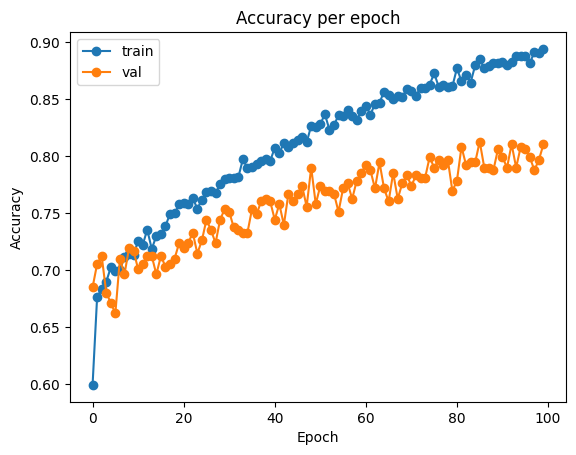

In [32]:
plt.plot(his['train_acc'], label='train', marker='o')
plt.plot(his['val_acc'], label='val', marker='o')
plt.title('Accuracy per epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

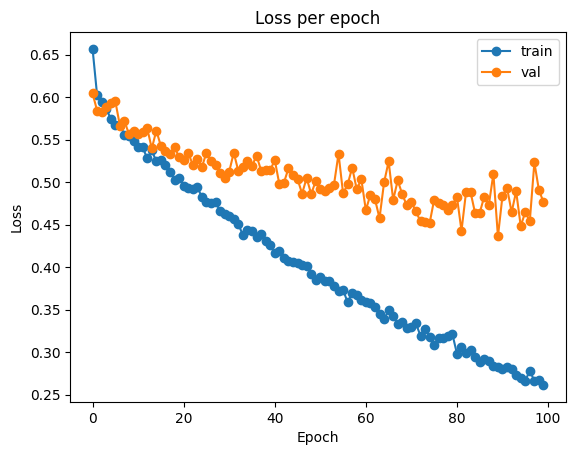

In [33]:
plt.plot(his['train_loss'], label='train', marker='o')
plt.plot(his['val_loss'], label='val', marker='o')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Test evaluting


In [34]:
def show_model(p_test, Y_test):
    test_predict = pd.DataFrame(p_test)

    balanced_accuracy = metrics.balanced_accuracy_score(Y_test, test_predict)
    accuracy = metrics.accuracy_score(Y_test, test_predict)
    precision = metrics.precision_score(Y_test, test_predict)
    recall = metrics.recall_score(Y_test, test_predict)
    f1 = metrics.f1_score(Y_test, test_predict, labels=['0','1'])
    roc_auc = metrics.roc_auc_score(Y_test, test_predict, labels=['0','1'])

    print('Balanced Accuracy = {:.3f}'.format(balanced_accuracy))
    print('Accuracy = {:.3f}'.format(accuracy))
    print('Precision = {:.3f}'.format(precision))
    print('Recall = {:.3f}'.format(recall))
    print('F1 Score = {:.3f}'.format(f1))
    print('ROC AUC Score = {:.3f}'.format(roc_auc))

    cm = metrics.confusion_matrix(Y_test, test_predict)

    sensitivity = recall
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    g_mean = np.sqrt(sensitivity * specificity)

    print('Sensitivity = {:.3f}'.format(sensitivity))
    print('Specificity = {:.3f}'.format(specificity))
    print('G-mean = {:.3f}'.format(g_mean))

    print('Classification_report')
    print(metrics.classification_report(Y_test, test_predict, target_names=['0','1']))

    print('Confusion Matrix:')
    metrics.ConfusionMatrixDisplay(cm).plot()

In [35]:
model_ftt.load_state_dict(torch.load('./Feature_Tokenizer_Transformer_state.pth'))
test_acc, test_loss, y_test_pred = evaluating(model_ftt, test_load, criterion)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 0.7165
Test Loss: 0.7465


Balanced Accuracy = 0.508
Accuracy = 0.648
Precision = 0.200
Recall = 0.281
F1 Score = 0.234
ROC AUC Score = 0.508
Sensitivity = 0.281
Specificity = 0.734
G-mean = 0.454
Classification_report
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       919
           1       0.20      0.28      0.23       217

    accuracy                           0.65      1136
   macro avg       0.51      0.51      0.50      1136
weighted avg       0.70      0.65      0.67      1136

Confusion Matrix:


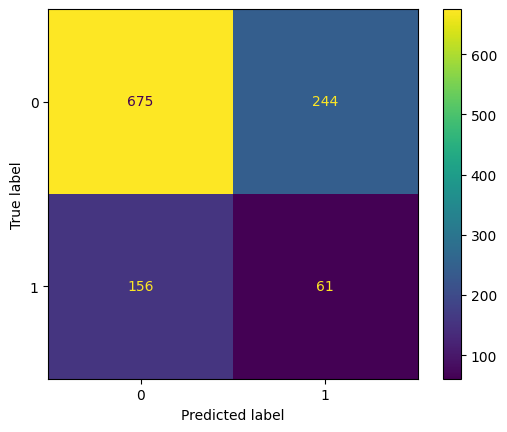

In [36]:
y_test_true = y['test'].cpu().numpy()
show_model(y_test_pred, y_test_true)

# Tuning

In [37]:
def tuning(model, train_loader, val_loader, criterion, optimizer):
    model.train()

    # train loader
    for x_num, label in train_loader:
        optimizer.zero_grad()
        x_num = x_num.to(device)
        label = label.to(device)
        out = torch.sigmoid(model(x_num, None))
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

    # val loader
    model.eval()
    with torch.no_grad():
        loss_now = 0
        correlation = 0

        for x_num, label in val_loader:
            x_num = x_num.to(device)
            label = label.to(device)
            out = torch.sigmoid(model(x_num, None))
            pred = out >= torch.FloatTensor([0.5]).to(device)
            correlation += pred.eq(label).sum().item()
            loss_now += x_num.size(0) * criterion(out, label).item()

    val_acc = correlation/len(val_loader.dataset)
    val_loss = loss_now/ len(val_loader.dataset)

    return val_acc, val_loss

In [38]:
# optuna
# hyperparameter
# suggest_uniform, suggest_loguniform -> suggest_float, suggest_float(log=True)
def objective(trial, train_loader, val_loader):
    d_token = trial.suggest_categorical('d_token', [64, 128, 256, 512])
    n_blocks = trial.suggest_int('n_blocks', 1, 4, log=True)
    attention_dropout = trial.suggest_float('attention_dropout', 0, 0.5)
    ffn_d_hidden = trial.suggest_int('ffn_d_hidden', 64, 1028)
    ffn_dropout = trial.suggest_float('ffn_dropout', 0, 0.5)
    residual_dropout = trial.suggest_float('residual_dropout', 0, 0.2)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weigth_decay', 1e-6, 1e-3, log=True)

    model_ftt = rtdl.FTTransformer.make_baseline(n_num_features=num_features,
                                             cat_cardinalities=[],
                                             d_token=d_token,
                                             n_blocks=n_blocks,
                                             attention_dropout=attention_dropout,
                                             ffn_d_hidden=ffn_d_hidden,
                                             ffn_dropout=ffn_dropout,
                                             residual_dropout=residual_dropout,
                                             d_out=1)
    model_ftt.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model_ftt.parameters(), lr=lr, weight_decay=weight_decay)

    n_epochs = 15
    min_loss = np.inf

    for epoch in range(n_epochs):
        val_acc, val_loss = tuning(model_ftt, train_loader, val_loader, criterion, optimizer)
        if min_loss > val_loss:
            min_loss = val_loss

    return min_loss

In [39]:
study = optuna.create_study(study_name='FT-Transformer', direction='minimize', sampler=TPESampler(seed=21))
study.optimize(lambda trial: objective(trial, train_load, val_load), n_trials=50)
print('\nBest Score:', study.best_value)
print('Best trial:', study.best_trial.params)

[I 2023-12-18 19:19:22,240] A new study created in memory with name: FT-Transformer
[I 2023-12-18 19:19:40,106] Trial 0 finished with value: 0.5877066672392631 and parameters: {'d_token': 256, 'n_blocks': 1, 'attention_dropout': 0.0253866283476884, 'ffn_d_hidden': 355, 'ffn_dropout': 0.33195514731235, 'residual_dropout': 0.06162287864737577, 'lr': 0.0005633442017222582, 'weigth_decay': 1.6170105887878455e-06}. Best is trial 0 with value: 0.5877066672392631.
[I 2023-12-18 19:20:06,461] Trial 1 finished with value: 0.5440759364872763 and parameters: {'d_token': 64, 'n_blocks': 3, 'attention_dropout': 0.37947191775605715, 'ffn_d_hidden': 1000, 'ffn_dropout': 0.3796512763927764, 'residual_dropout': 0.07685000641802589, 'lr': 0.00016832746705566732, 'weigth_decay': 0.00013806426449912442}. Best is trial 1 with value: 0.5440759364872763.
[I 2023-12-18 19:20:26,588] Trial 2 finished with value: 0.5250771200820191 and parameters: {'d_token': 256, 'n_blocks': 2, 'attention_dropout': 0.083917882


Best Score: 0.4598969765449768
Best trial: {'d_token': 128, 'n_blocks': 4, 'attention_dropout': 0.05633571882908772, 'ffn_d_hidden': 529, 'ffn_dropout': 0.15680906610269654, 'residual_dropout': 0.023306414142002692, 'lr': 0.00018315266700252362, 'weigth_decay': 4.7121678184506015e-06}


In [40]:
optuna.visualization.plot_optimization_history(study)

In [41]:
optuna.visualization.plot_param_importances(study)

In [43]:
study.best_trial.params

{'d_token': 128,
 'n_blocks': 4,
 'attention_dropout': 0.05633571882908772,
 'ffn_d_hidden': 529,
 'ffn_dropout': 0.15680906610269654,
 'residual_dropout': 0.023306414142002692,
 'lr': 0.00018315266700252362,
 'weigth_decay': 4.7121678184506015e-06}

# Training again

In [57]:

model_ftt = rtdl.FTTransformer.make_baseline(n_num_features=X['train']['num'].shape[1],
                                            cat_cardinalities=[],
                                            d_token=study.best_trial.params['d_token'],
                                            n_blocks=study.best_trial.params['n_blocks'],
                                            attention_dropout=study.best_trial.params['attention_dropout'],
                                            ffn_d_hidden=study.best_trial.params['ffn_d_hidden'],
                                            ffn_dropout=study.best_trial.params['ffn_dropout'],
                                            residual_dropout=study.best_trial.params['residual_dropout'],
                                            d_out=1)
model_ftt.to(device)

FTTransformer(
  (feature_tokenizer): FeatureTokenizer(
    (num_tokenizer): NumericalFeatureTokenizer()
  )
  (cls_token): CLSToken()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=128, out_features=128, bias=True)
          (W_k): Linear(in_features=128, out_features=128, bias=True)
          (W_v): Linear(in_features=128, out_features=128, bias=True)
          (W_out): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.05633571882908772, inplace=False)
        )
        (ffn): FFN(
          (linear_first): Linear(in_features=128, out_features=1058, bias=True)
          (activation): ReGLU()
          (dropout): Dropout(p=0.15680906610269654, inplace=False)
          (linear_second): Linear(in_features=529, out_features=128, bias=True)
        )
        (attention_residual_dropout): Dropout(p=0.023306414142002692, inplace=False)
        (ffn

In [58]:
his = {'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []}

criterion = nn.BCELoss()
optimizer = optim.AdamW(model_ftt.parameters(),
                        lr = study.best_trial.params['lr'],
                        weight_decay=study.best_trial.params['weigth_decay'])

n_epochs = 50
maxLoss = np.inf

for epoch in range(n_epochs):
    train_acc, train_loss = training(model_ftt, train_load, criterion, optimizer, None)
    val_acc, val_loss, y_val_pred = evaluating(model_ftt, val_load, criterion)

    if val_loss < maxLoss:
        print(f'EPOCH {epoch+1}: Saving state of model')
        maxLoss = val_loss
        torch.save(model_ftt.state_dict(), 'FTT_model_Best_Tunning.pth')

    print(f'Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}')
    print(f'Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}\n')


100%|██████████| 123/123 [00:02<00:00, 51.68it/s]


EPOCH 1: Saving state of model
Train Accuracy: 0.6466, Train Loss: 0.6271
Val Accuracy: 0.6461, Val Loss: 0.6038



100%|██████████| 123/123 [00:02<00:00, 51.81it/s]


Train Accuracy: 0.6839, Train Loss: 0.5831
Val Accuracy: 0.6484, Val Loss: 0.6100



100%|██████████| 123/123 [00:02<00:00, 51.64it/s]


EPOCH 3: Saving state of model
Train Accuracy: 0.7022, Train Loss: 0.5614
Val Accuracy: 0.7055, Val Loss: 0.5628



100%|██████████| 123/123 [00:02<00:00, 43.53it/s]


Train Accuracy: 0.7172, Train Loss: 0.5415
Val Accuracy: 0.6986, Val Loss: 0.5781



100%|██████████| 123/123 [00:02<00:00, 44.02it/s]


EPOCH 5: Saving state of model
Train Accuracy: 0.7317, Train Loss: 0.5220
Val Accuracy: 0.7100, Val Loss: 0.5527



100%|██████████| 123/123 [00:02<00:00, 52.71it/s]


EPOCH 6: Saving state of model
Train Accuracy: 0.7419, Train Loss: 0.5083
Val Accuracy: 0.7078, Val Loss: 0.5405



100%|██████████| 123/123 [00:02<00:00, 51.81it/s]


EPOCH 7: Saving state of model
Train Accuracy: 0.7566, Train Loss: 0.4872
Val Accuracy: 0.7009, Val Loss: 0.5392



100%|██████████| 123/123 [00:02<00:00, 52.35it/s]


Train Accuracy: 0.7731, Train Loss: 0.4657
Val Accuracy: 0.6941, Val Loss: 0.5528



100%|██████████| 123/123 [00:02<00:00, 41.71it/s]


EPOCH 9: Saving state of model
Train Accuracy: 0.7764, Train Loss: 0.4582
Val Accuracy: 0.7123, Val Loss: 0.5274



100%|██████████| 123/123 [00:02<00:00, 46.32it/s]


EPOCH 10: Saving state of model
Train Accuracy: 0.7901, Train Loss: 0.4404
Val Accuracy: 0.7420, Val Loss: 0.5115



100%|██████████| 123/123 [00:02<00:00, 50.80it/s]


Train Accuracy: 0.8092, Train Loss: 0.4139
Val Accuracy: 0.7580, Val Loss: 0.5193



100%|██████████| 123/123 [00:02<00:00, 51.08it/s]


Train Accuracy: 0.8288, Train Loss: 0.3840
Val Accuracy: 0.7671, Val Loss: 0.5352



100%|██████████| 123/123 [00:02<00:00, 51.56it/s]


Train Accuracy: 0.8257, Train Loss: 0.3757
Val Accuracy: 0.7374, Val Loss: 0.5306



100%|██████████| 123/123 [00:03<00:00, 40.77it/s]


EPOCH 14: Saving state of model
Train Accuracy: 0.8361, Train Loss: 0.3679
Val Accuracy: 0.7922, Val Loss: 0.4659



100%|██████████| 123/123 [00:02<00:00, 48.87it/s]


Train Accuracy: 0.8547, Train Loss: 0.3327
Val Accuracy: 0.7808, Val Loss: 0.4883



100%|██████████| 123/123 [00:02<00:00, 53.54it/s]


Train Accuracy: 0.8516, Train Loss: 0.3225
Val Accuracy: 0.7671, Val Loss: 0.5314



100%|██████████| 123/123 [00:02<00:00, 50.85it/s]


Train Accuracy: 0.8605, Train Loss: 0.3117
Val Accuracy: 0.7557, Val Loss: 0.5055



100%|██████████| 123/123 [00:02<00:00, 51.99it/s]


EPOCH 18: Saving state of model
Train Accuracy: 0.8720, Train Loss: 0.2952
Val Accuracy: 0.8105, Val Loss: 0.4526



100%|██████████| 123/123 [00:03<00:00, 40.23it/s]


Train Accuracy: 0.8768, Train Loss: 0.2861
Val Accuracy: 0.7785, Val Loss: 0.4902



100%|██████████| 123/123 [00:02<00:00, 49.57it/s]


EPOCH 20: Saving state of model
Train Accuracy: 0.8905, Train Loss: 0.2600
Val Accuracy: 0.8311, Val Loss: 0.4451



100%|██████████| 123/123 [00:02<00:00, 51.82it/s]


Train Accuracy: 0.8897, Train Loss: 0.2595
Val Accuracy: 0.8128, Val Loss: 0.4974



100%|██████████| 123/123 [00:02<00:00, 52.44it/s]


EPOCH 22: Saving state of model
Train Accuracy: 0.8994, Train Loss: 0.2450
Val Accuracy: 0.8059, Val Loss: 0.4365



100%|██████████| 123/123 [00:02<00:00, 51.25it/s]


EPOCH 23: Saving state of model
Train Accuracy: 0.9002, Train Loss: 0.2374
Val Accuracy: 0.8174, Val Loss: 0.4167



100%|██████████| 123/123 [00:03<00:00, 39.42it/s]


EPOCH 24: Saving state of model
Train Accuracy: 0.9088, Train Loss: 0.2140
Val Accuracy: 0.8425, Val Loss: 0.3811



100%|██████████| 123/123 [00:02<00:00, 52.00it/s]


Train Accuracy: 0.9223, Train Loss: 0.1978
Val Accuracy: 0.8219, Val Loss: 0.4706



100%|██████████| 123/123 [00:02<00:00, 52.83it/s]


Train Accuracy: 0.9215, Train Loss: 0.1947
Val Accuracy: 0.8082, Val Loss: 0.5028



100%|██████████| 123/123 [00:02<00:00, 52.49it/s]


Train Accuracy: 0.9266, Train Loss: 0.1810
Val Accuracy: 0.8379, Val Loss: 0.4532



100%|██████████| 123/123 [00:02<00:00, 51.31it/s]


Train Accuracy: 0.9332, Train Loss: 0.1668
Val Accuracy: 0.8402, Val Loss: 0.4193



100%|██████████| 123/123 [00:03<00:00, 37.90it/s]


Train Accuracy: 0.9286, Train Loss: 0.1724
Val Accuracy: 0.8151, Val Loss: 0.5281



100%|██████████| 123/123 [00:02<00:00, 51.57it/s]


Train Accuracy: 0.9380, Train Loss: 0.1587
Val Accuracy: 0.8082, Val Loss: 0.5348



100%|██████████| 123/123 [00:02<00:00, 52.37it/s]


Train Accuracy: 0.9309, Train Loss: 0.1734
Val Accuracy: 0.8174, Val Loss: 0.4618



100%|██████████| 123/123 [00:02<00:00, 52.84it/s]


Train Accuracy: 0.9413, Train Loss: 0.1457
Val Accuracy: 0.8333, Val Loss: 0.5414



100%|██████████| 123/123 [00:02<00:00, 52.53it/s]


Train Accuracy: 0.9472, Train Loss: 0.1304
Val Accuracy: 0.8402, Val Loss: 0.5362



100%|██████████| 123/123 [00:03<00:00, 38.38it/s]


Train Accuracy: 0.9510, Train Loss: 0.1243
Val Accuracy: 0.8311, Val Loss: 0.5348



100%|██████████| 123/123 [00:02<00:00, 50.73it/s]


Train Accuracy: 0.9535, Train Loss: 0.1208
Val Accuracy: 0.8493, Val Loss: 0.4669



100%|██████████| 123/123 [00:03<00:00, 36.56it/s]


Train Accuracy: 0.9515, Train Loss: 0.1325
Val Accuracy: 0.8288, Val Loss: 0.5442



100%|██████████| 123/123 [00:02<00:00, 45.92it/s]


Train Accuracy: 0.9515, Train Loss: 0.1283
Val Accuracy: 0.8630, Val Loss: 0.4769



100%|██████████| 123/123 [00:02<00:00, 44.15it/s]


Train Accuracy: 0.9586, Train Loss: 0.1192
Val Accuracy: 0.8699, Val Loss: 0.4357



100%|██████████| 123/123 [00:02<00:00, 43.17it/s]


Train Accuracy: 0.9563, Train Loss: 0.1121
Val Accuracy: 0.8379, Val Loss: 0.5569



100%|██████████| 123/123 [00:02<00:00, 44.78it/s]


Train Accuracy: 0.9533, Train Loss: 0.1164
Val Accuracy: 0.8402, Val Loss: 0.5078



100%|██████████| 123/123 [00:02<00:00, 51.64it/s]


Train Accuracy: 0.9637, Train Loss: 0.0960
Val Accuracy: 0.8630, Val Loss: 0.5382



100%|██████████| 123/123 [00:02<00:00, 52.14it/s]


Train Accuracy: 0.9593, Train Loss: 0.1038
Val Accuracy: 0.8584, Val Loss: 0.4858



100%|██████████| 123/123 [00:03<00:00, 39.37it/s]


Train Accuracy: 0.9715, Train Loss: 0.0761
Val Accuracy: 0.8744, Val Loss: 0.5079



100%|██████████| 123/123 [00:02<00:00, 48.66it/s]


Train Accuracy: 0.9601, Train Loss: 0.1061
Val Accuracy: 0.8379, Val Loss: 0.4923



100%|██████████| 123/123 [00:02<00:00, 51.59it/s]


Train Accuracy: 0.9606, Train Loss: 0.0966
Val Accuracy: 0.8653, Val Loss: 0.4530



100%|██████████| 123/123 [00:02<00:00, 50.93it/s]


Train Accuracy: 0.9657, Train Loss: 0.0848
Val Accuracy: 0.8516, Val Loss: 0.5932



100%|██████████| 123/123 [00:02<00:00, 51.75it/s]


Train Accuracy: 0.9642, Train Loss: 0.0915
Val Accuracy: 0.8607, Val Loss: 0.5176



100%|██████████| 123/123 [00:03<00:00, 38.73it/s]


Train Accuracy: 0.9685, Train Loss: 0.0790
Val Accuracy: 0.8630, Val Loss: 0.4909



100%|██████████| 123/123 [00:02<00:00, 50.97it/s]


Train Accuracy: 0.9710, Train Loss: 0.0774
Val Accuracy: 0.8721, Val Loss: 0.4540



100%|██████████| 123/123 [00:02<00:00, 51.76it/s]


Train Accuracy: 0.9733, Train Loss: 0.0780
Val Accuracy: 0.8813, Val Loss: 0.4882



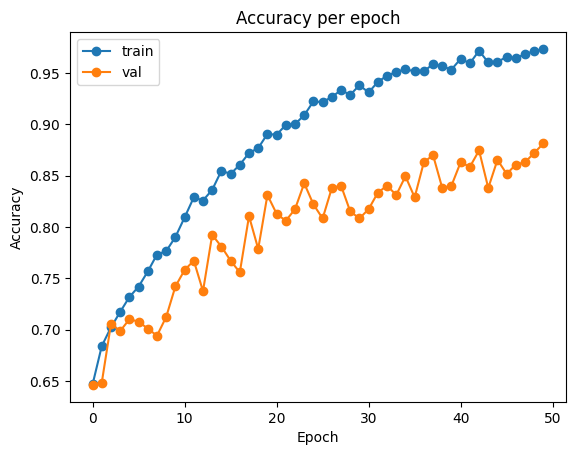

In [59]:
# plot accuracy
plt.plot(his['train_acc'], label='train', marker='o')
plt.plot(his['val_acc'], label='val', marker='o')
plt.title('Accuracy per epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

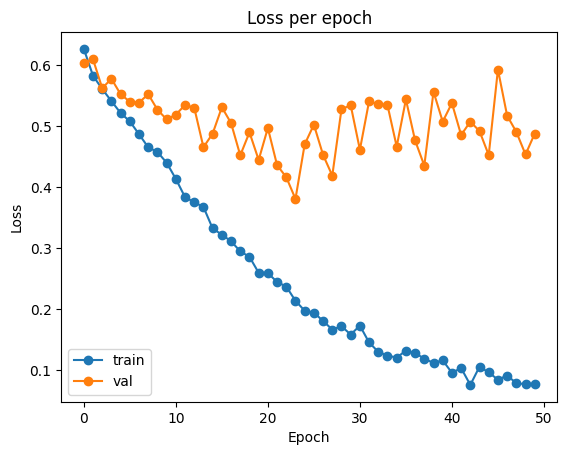

In [60]:
plt.plot(his['train_loss'], label='train', marker='o')
plt.plot(his['val_loss'], label='val', marker='o')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [61]:
# test evaluating
model_ftt.load_state_dict(torch.load('./FTT_model_Best_Tunning.pth'))
test_acc, test_loss, y_test_pred = evaluating(model_ftt, test_load, criterion)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 0.7254
Test Loss: 0.7337


Balanced Accuracy = 0.495
Accuracy = 0.648
Precision = 0.186
Recall = 0.249
F1 Score = 0.213
ROC AUC Score = 0.495
Sensitivity = 0.249
Specificity = 0.742
G-mean = 0.430
Classification_report
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       919
           1       0.19      0.25      0.21       217

    accuracy                           0.65      1136
   macro avg       0.50      0.50      0.49      1136
weighted avg       0.69      0.65      0.67      1136

Confusion Matrix:


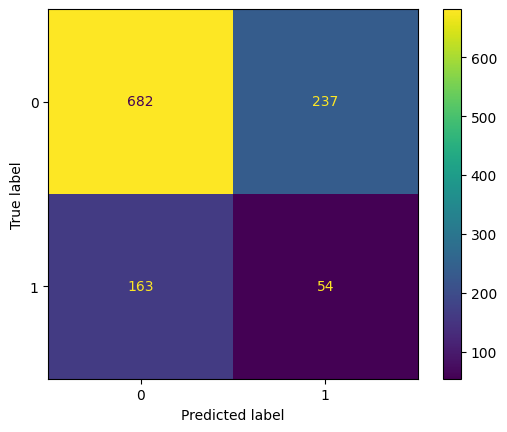

In [62]:
show_model(y_test_pred, y_test_true)